In [15]:
import pandas as pd
from mphelper import ProcessWrapPool
from biodata.delimited import DelimitedWriter
import subprocess
import numpy as np
import seaborn as sns
from statsmodels.stats import multitest
from collections import defaultdict
import matplotlib
import matplotlib.pyplot as plt
import itertools
from biodatatools.utils.common import json_load
from pathlib import Path
import glob

In [90]:
font_dir = Path.cwd().parent / "font"
for font in ["Arial.ttf", "Arial_Bold.ttf"]:
    matplotlib.font_manager.fontManager.addfont(font_dir / font)
matplotlib.rcParams["font.family"] = "Arial"
bfontsize = 12
sfontsize = 9
lw = 0.8

In [29]:
PROJECT_DIR_s = "/fs/cbsuhy02/storage/yc2553/yc2553/softwares/ldsc/"
PROJECT_DIR_d = "/home/yc2553/projects/HEA/databases/"
PROJECT_DIR_o = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/3.Human_atlas/output/"
PROJECT_DIR_o2 = "/home/yc2553/projects/HEA/output/"

# Run S-LDSC

In [18]:
files = glob.glob(f"{PROJECT_DIR_s}all_sumstats/*.sumstats")
sumstats = [f.split("/")[-1].split(".sumstats")[0] for f in files]
len(sumstats)

176

In [33]:
cdict = json_load(f"{PROJECT_DIR_d}PROcap/metainfo/color_codes.json")
tissues = ["_".join(t.split(" ")) for t in cdict] + ["Non_tissue_specific"]

In [19]:
p = "divergent"
ds = ["distal", "proximal"]
dir1 = f"{PROJECT_DIR_o}LDSC/annots/0.05_1000/"
dir2 = f"{PROJECT_DIR_o}LDSC/cts/0.05_1000/"

In [7]:
for d in ds:
	outputfile = f"{dir2}{p}_{d}/cts.txt"
	with DelimitedWriter(outputfile) as dw:
		for t in tissues:
			dw.write([f"{p}_{d}_{t}", f"{dir1}{p}_{d}_{t}."])

In [11]:
# Recommendations for cell-type specific analyses:
# 1. We recommend that for identifying critical tissues/cell-types via P-value of tau, it is best to use the baseline model, specifically baseline v1.2.
# 2. We recommend that for estimating heritability enrichment (i.e., %h2/%SNPs) of any annotation, including tissue-specific annotations, it is best to use baselineLD v2.2.    
# gs://broad-alkesgroup-public-requester-pays/LDSCORE/GRCh38/baseline_v1.2.tgz

ref_ld_chr = f"{PROJECT_DIR_s}hg38/baseline_v1.2/baseline."

In [12]:
# gs://broad-alkesgroup-public-requester-pays/LDSCORE/GRCh38/weights.tgz

w_ld_chr = f"{PROJECT_DIR_s}hg38/weights/weights.hm3_noMHC."

In [13]:
def get_cts(sumstat, ref_ld_chr, ref_ld_chr_cts, w_ld_chr, output_prefix):
	script = "/home/yc2553/slurm/LDSC/cell_type_specificity.sh"
	commands = " ".join(["bash", script,
						sumstat,
						ref_ld_chr,
						ref_ld_chr_cts,
						w_ld_chr,
						output_prefix
						])
	subprocess.run(commands, shell=True)

In [26]:
pwpool = ProcessWrapPool(30)

for p, d in itertools.product(ps, ds):
	ref_ld_chr_cts = f"{dir2}{p}_{d}/cts.txt"
	for sid in sumstats:
		output_prefix = f"{dir2}{p}_{d}/{sid}"
		outputfile = f"{dir2}{p}_{d}/{sid}.cell_type_results.txt"
		pwpool.run(get_cts, args=[f"{PROJECT_DIR_s}all_sumstats/{sid}.sumstats", ref_ld_chr, ref_ld_chr_cts, w_ld_chr, output_prefix])

In [28]:
len(pwpool.finished_tasks)

352

In [29]:
pwpool.close()

In [24]:
# The first column: the labels from the first column of the .ldcts file. 
# The next two columns: the estimate and standard error of the first regression coefficient from the regression; i.e., the first regression coefficient of the first set of LD scores in the corresponding line of the .ldcts file. In the .ldcts files provided, this will be the regression coefficient corresponding to the cell type specific annotation: either the set of specifically expressed genes, or the peaks of chromatin mark. 
# The last column: a P-value from a one-sided test that the coefficient is greater than zero. We recommend using this for significance testing, with appropriate correction for multiple testing.

inputfile = f"{dir2}{p}_{d}/{sid}.cell_type_results.txt"
df = pd.read_table(inputfile)
df.head(2)

,Name,Coefficient,Coefficient_std_error,Coefficient_P_value
0,divergent_distal_Brain,1.188740e-07,2.437539e-08,5.390853e-07
1,divergent_distal_Testis,3.203834e-08,1.871640e-08,4.346873e-02


In [41]:
# Combine all dataframes

results = []
df_alls = {}
for d in ds:
	dfs = []
	for sid in sumstats:
		inputfile = f"{dir2}{p}_{d}/{sid}.cell_type_results.txt"
		df = pd.read_table(inputfile)
		df["Pheno"] = sid
		dfs.append(df)
	df_all = pd.concat(dfs, ignore_index=True)
	df_all["FDR"] = multitest.fdrcorrection(list(df_all["Coefficient_P_value"]), alpha=0.05, method="indep", is_sorted=False)[1]
	df_all["-log10adjp"] = -np.log10(df_all["FDR"])
	df_alls[d] = df_all
	results.append([(p, d),
					len(df_all),
					 len(df_all[df_all["FDR"]<0.05]),
					 max(df_all["-log10adjp"])
					 ])
pd.DataFrame(results, columns=["Group", "No. all pheno-tissue pairs", "No. pairs with FDR < 0.05", "Max"])

,Group,No. all pheno-tissue pairs,No. pairs with FDR < 0.05,Max
0,"(divergent, distal)",2816,101,5.827175
1,"(divergent, proximal)",2816,33,3.638974


# Heatmaps for enrichment

In [42]:
# Generate heatmaps for enrichment
# Each row: one tissue type
# Each column: one GWAS phenotype

df_FDR = {}
for d in ds:
	results = []
	for t in tissues:
		row = []
		for sid in sumstats:
			df = df_alls[d][(df_alls[d]["Name"]==f"{p}_{d}_{t}") & (df_alls[d]["Pheno"]==sid)]
			row.append(list(df["-log10adjp"])[0])
		results.append(row)
	df_FDR[d] = pd.DataFrame(results, columns=sumstats, index=[" ".join(t.split("_")).capitalize() if t != "Non_tissue_specific" else "Non-tissue-specific" for t in tissues])

In [45]:
df_FDR[d].head(2)

,PASS_MDD_Howard2019,PASS_ADHD_Demontis2018,PASS_Ever_Smoked,PASS_AdultOnsetAsthma_Ferreira2019,PASS_ProstateCancer,PASS_AgeFirstBirth,PASS_MDD_Wray2018,PASS_AgeOfInitiation_Liu2019,PASS_Rheumatoid_Arthritis,PASS_Alzheimer,...,UKB_460K.pigment_HAIR_darkbrown,UKB_460K.pigment_SKIN,UKB_460K.pigment_SUNBURN,UKB_460K.pigment_TANNING,UKB_460K.repro_AgeFirstBirth_Female,UKB_460K.repro_MENARCHE_AGE,UKB_460K.repro_MENOPAUSE_AGE,UKB_460K.repro_NumberChildrenEverBorn_Female,UKB_460K.repro_NumberChildrenEverBorn_Male,UKB_460K.repro_NumberChildrenEverBorn_Pooled
Blood,0.000001,0.028876,0.009347,0.042437,0.000001,0.000001,0.000001,0.000001,0.071067,0.000001,...,0.004578,0.003636,0.000001,0.000001,0.000001,0.000001,0.100324,0.000001,0.011545,0.000001
Lymph node,0.003636,0.009347,0.000001,0.158155,0.054963,0.157712,0.028876,0.055427,0.648851,0.000001,...,0.000001,0.000001,0.006509,0.000001,0.000001,0.000001,0.000001,0.058233,0.066632,0.163000


In [44]:
def sort_columns(df):	
	cols_order = []
	# For each phenotype, find the tissue type that has the highest enrichment
	tops = defaultdict(list)
	for col in df.columns:
		sorted_df = df.sort_values(by=col, ascending=False)
		tops[sorted_df.iloc[0].name].append(col)

	# For each tissue type, further sort the phenotypes by enrichment
	for t in df.index:
		sorted_df = df[tops[t]].loc[t].sort_values(ascending=False)
		cols_order.extend(list(sorted_df.index))
	
	return cols_order

In [48]:
# Sort distal group; use the same order for proximal group as we only show yticklabels once to save some space

order = sort_columns(df_FDR["distal"])
df_sorted = {}
for d in ds:
	df_sorted[d] = df_FDR[d][order]

In [93]:
def annotate_cutoff(val):
	if val > -np.log10(0.1):
		return "*"
	else:
		return ""

In [96]:
vlims = [0,1,2,3]

In [78]:
def heatmap(df, title, outputfile, yticklabels=True, plot_cbar=True):
	fig, ax = plt.subplots(figsize=(5.5,14))
	g = sns.heatmap(df, cmap="Reds", ax=ax, 
					xticklabels=True, yticklabels=yticklabels,
					cbar=False, vmin=vlims[0], vmax=vlims[-1],
					annot=df.map(lambda x: annotate_cutoff(x)), 
					fmt='', annot_kws={"fontsize": sfontsize, "va": "center"}
				   )
	for text in g.texts:
		if text.get_text() == "*":
			x, y = text.get_position()
			text.set_position((x, y+0.5))
			
	if plot_cbar:
		cbar = g.collections[0].colorbar
		cbar_ax = fig.add_axes([0.95, 0.8, 0.03, 0.05])
		cbar = plt.colorbar(g.collections[0], cax=cbar_ax)
		cbar.set_label("-log$_{10}$FDR", fontsize=bfontsize)
		cbar.set_ticks(vlims)
		cbar.set_ticklabels([str(v) for v in vlims])
		cbar.ax.tick_params(labelsize=sfontsize)

	g.set_title(title, fontsize=bfontsize)
	g.set_xlabel("")
	g.tick_params(axis="x", labelsize=bfontsize, rotation=30)
	for label in g.get_xticklabels():
	    label.set_horizontalalignment("right")
	g.set_ylabel("")
	g.tick_params(axis="y", labelsize=5)
				
	plt.savefig(outputfile, bbox_inches='tight', transparent=True)

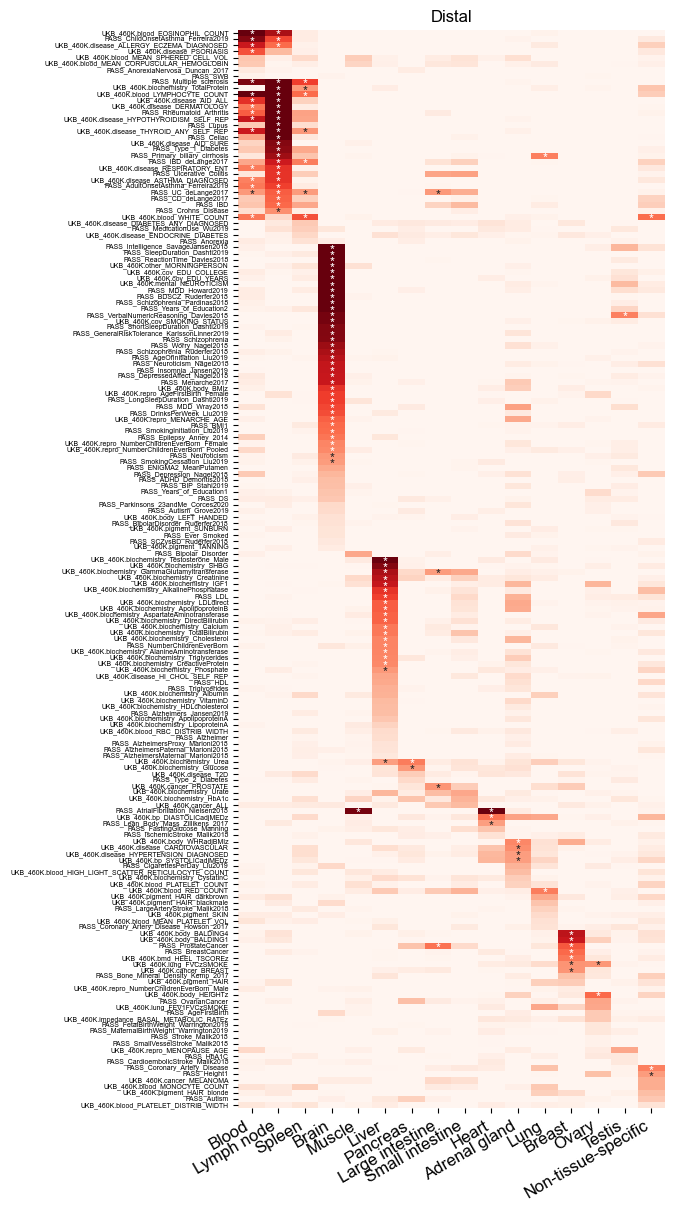

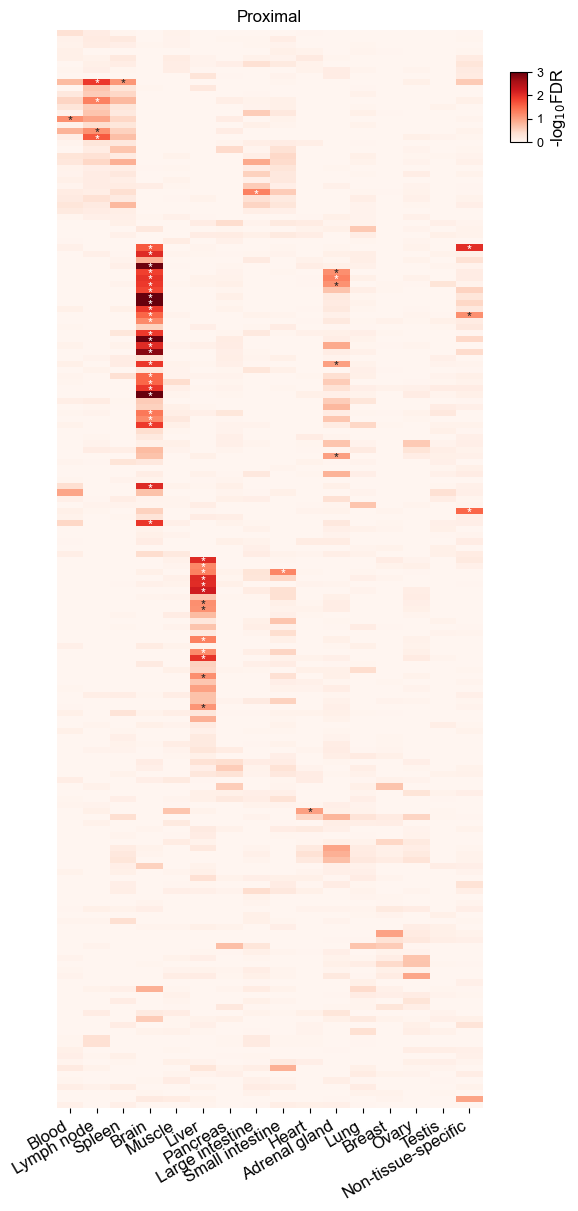

In [80]:
for d in ds:
	figN = "a" if d == "distal" else "b"
	outputfile = f"{PROJECT_DIR_o2}figures/SuppFig3{figN}.pdf"
	yticklabels = True if d == "distal" else False
	plot_cbar = False if d == "distal" else True
	heatmap(df_sorted[d].T, d.capitalize(), outputfile, yticklabels, plot_cbar)

In [88]:
# For main figure, we highlight tissues showing enrichment for multiple traits

d = "distal"
tissues_keep = ["Blood", "Lymph node", "Spleen", "Large intestine", "Brain", "Liver", "Heart", "Adrenal gland"]
df = df_sorted[d].loc[tissues_keep]
traits = df.loc[:, (df > -np.log10(0.1)).any()].columns
# Manually check the traits and keep the biologically relevant ones
traits_keep = [trait for trait in traits if trait not in ['PASS_Lean_Body_Mass_Zillikens_2017', 'UKB_460K.body_WHRadjBMIz', 'UKB_460K.cancer_PROSTATE', 'PASS_ProstateCancer']]

In [91]:
# Reorder the traits; put IBD related at the end of immune-related traits
ind = traits_keep.index('PASS_Intelligence_SavageJansen2018')
immune_traits = traits_keep[: ind]
IBD_traits = ['PASS_IBD', 'PASS_IBD_deLange2017', 
			  'PASS_Crohns_Disease', 'PASS_CD_deLange2017', 
			  'PASS_Ulcerative_Colitis', 'PASS_UC_deLange2017']
immune_traits_reordered = [trait for trait in immune_traits if trait not in IBD_traits] + IBD_traits

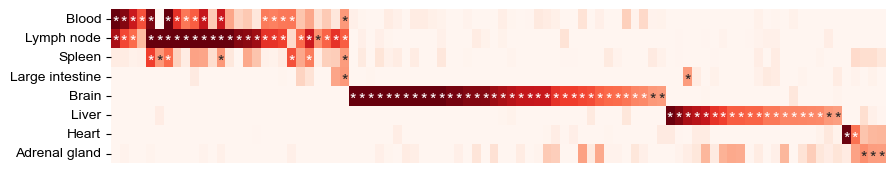

In [116]:
df_final = df[immune_traits_reordered+[trait for trait in traits_keep if trait not in immune_traits_reordered]]
fig, ax = plt.subplots(figsize=(10,2))
g = sns.heatmap(df_final, cmap="Reds", ax=ax, linewidth=0.001,
					xticklabels=False, yticklabels=True,
					cbar=False, vmin=vlims[0], vmax=vlims[-1],
					annot=df_final.map(lambda x: annotate_cutoff(x)), 
					fmt='', annot_kws={"fontsize": bfontsize, "va": "center"}
				   )
for text in g.texts:
	if text.get_text() == "*":
		x, y = text.get_position()
		text.set_position((x, y+0.2))

plt.savefig(f"{PROJECT_DIR_o2}figures/Fig3a.pdf", bbox_inches='tight', transparent=True)